In [ ]:
!kaggle competitions download -c playground-series-s5e2
!kaggle datasets download souradippal/student-bag-price-prediction-dataset

!unzip -u *.zip

playground-series-s5e2.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset URL: https://www.kaggle.com/datasets/souradippal/student-bag-price-prediction-dataset
License(s): MIT
student-bag-price-prediction-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  playground-series-s5e2.zip
caution: filename not matched:  student-bag-price-prediction-dataset.zip


In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

from sklearn import set_config
set_config(transform_output = "pandas")

from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.model_selection import cross_validate

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, TargetEncoder

from lightgbm import LGBMRegressor

KAGGLE_RUN = False
if KAGGLE_RUN:
    working_dir = Path('/kaggle/input/playground-series-s5e2')
else:
    working_dir = Path().cwd()


In [3]:
train_df = pd.concat([
    pd.read_csv(working_dir/'train.csv', index_col='id'),
    pd.read_csv(working_dir/'training_extra.csv', index_col='id')
    ])

test_df = pd.read_csv(working_dir/'test.csv', index_col='id')

original_df = pd.read_csv(working_dir/'Noisy_Student_Bag_Price_Prediction_Dataset.csv')

train_df

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
id,,,,,,,,,,
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312
...,...,...,...,...,...,...,...,...,...,...
4194313,Nike,Canvas,NaN,3.0,Yes,Yes,Messenger,Blue,28.098120,104.74460
4194314,Puma,Leather,Small,10.0,Yes,Yes,Tote,Blue,17.379531,122.39043
4194315,Jansport,Canvas,Large,10.0,No,No,Backpack,Red,17.037708,148.18470


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3994318 entries, 0 to 4194317
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Brand                 object 
 1   Material              object 
 2   Size                  object 
 3   Compartments          float64
 4   Laptop Compartment    object 
 5   Waterproof            object 
 6   Style                 object 
 7   Color                 object 
 8   Weight Capacity (kg)  float64
 9   Price                 float64
dtypes: float64(3), object(7)
memory usage: 335.2+ MB


In [4]:
CATEGORIC_COLUMNS = ['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
NUMERIC_COLUMNS = ['Weight Capacity (kg)']
TARGET_COLUMN = ['Price']

In [5]:
def get_unique_vals(df:pd.DataFrame, column:str) -> None:
    print(f'{column} has the following unique entries {len(df[column].unique())}')
    print(f'{df[column].value_counts()}')
    print('-----------------------------------')


for column in CATEGORIC_COLUMNS:
    get_unique_vals(train_df, column)


Brand has the following unique entries 6
Brand
Under Armour    801035
Adidas          797000
Nike            764407
Puma            755778
Jansport        749340
Name: count, dtype: int64
-----------------------------------
Material has the following unique entries 5
Material
Polyester    1060882
Leather       976186
Nylon         942656
Canvas        903632
Name: count, dtype: int64
-----------------------------------
Size has the following unique entries 4
Size
Medium    1354487
Large     1312295
Small     1239751
Name: count, dtype: int64
-----------------------------------
Compartments has the following unique entries 10
Compartments
1.0     423577
4.0     417246
2.0     408150
3.0     406796
7.0     400824
5.0     399418
9.0     398192
10.0    396303
8.0     383172
6.0     360640
Name: count, dtype: int64
-----------------------------------
Laptop Compartment has the following unique entries 3
Laptop Compartment
Yes    1972937
No     1922848
Name: count, dtype: int64
-------------

In [6]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Compartments,3994318.0,5.434740,2.893043,1.0,3.000000,5.00000,8.000000,10.0
Weight Capacity (kg),3992510.0,18.010417,6.973969,5.0,12.068964,18.05436,23.987505,30.0
Price,3994318.0,81.362175,38.938684,15.0,47.470020,80.98495,114.855000,150.0


<Axes: >

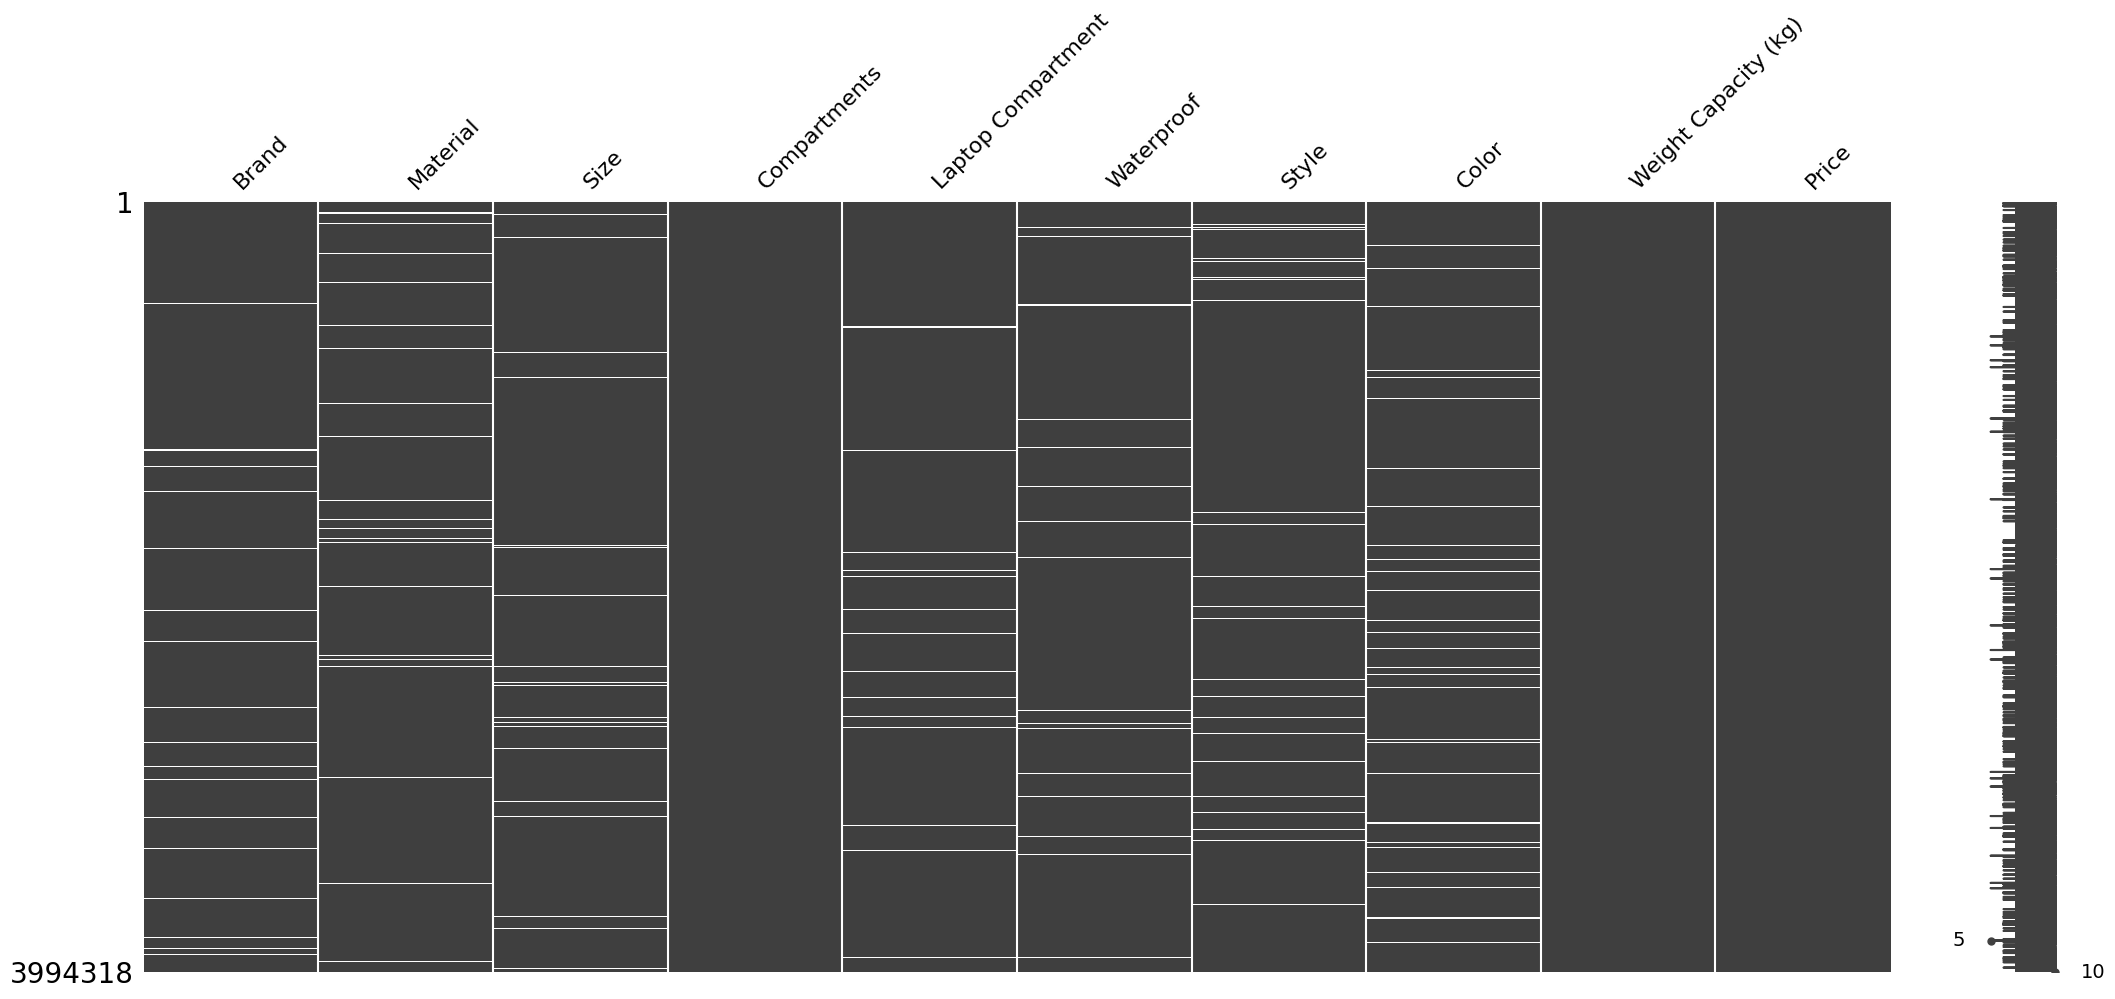

In [7]:
missingno.matrix(train_df)

<Axes: >

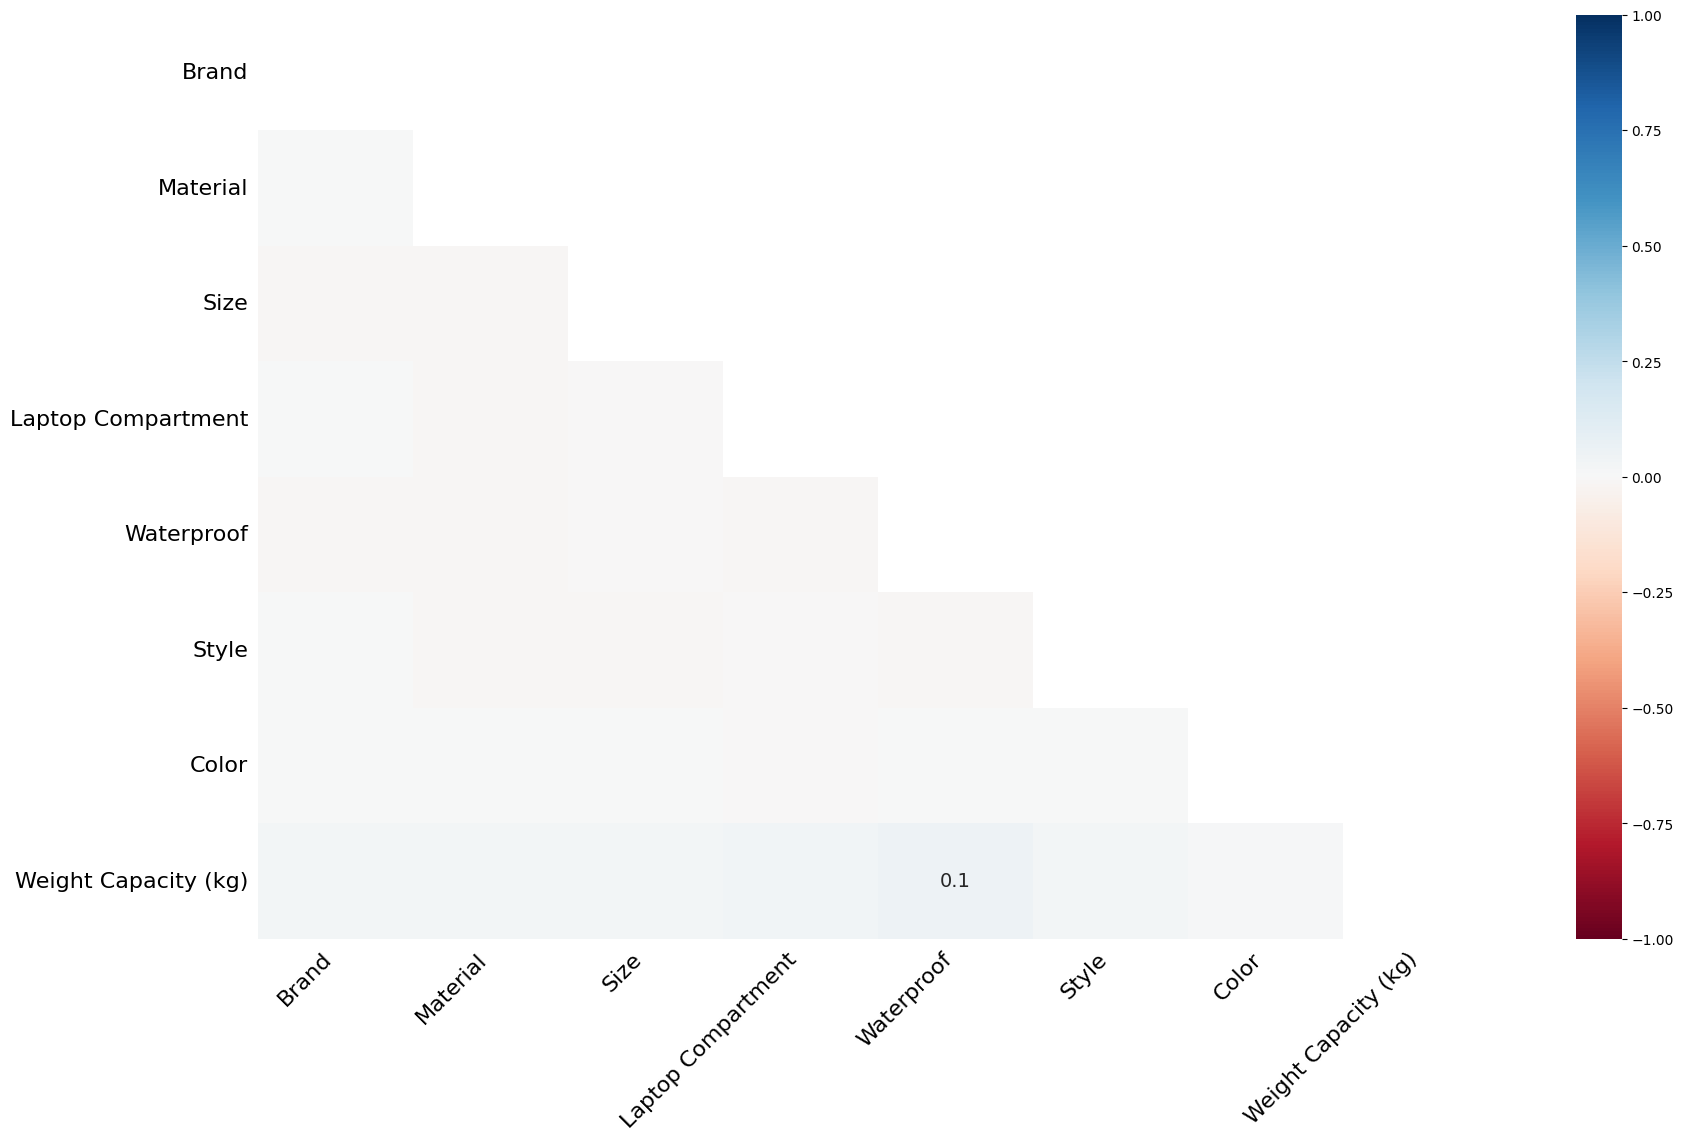

In [8]:
missingno.heatmap(train_df)

In [9]:
missing_values_train = pd.DataFrame({
    'Feature': train_df.columns,
    'No. of Missing Values': train_df.isnull().sum().values,
    '% of Missing Values': ((train_df.isnull().sum().values)/len(train_df)*100)
    })
missing_values_train

,Feature,No. of Missing Values,% of Missing Values
0,Brand,126758,3.173458
1,Material,110962,2.777996
2,Size,87785,2.197747
3,Compartments,0,0.000000
4,Laptop Compartment,98533,2.466829
5,Waterproof,94324,2.361454
6,Style,104180,2.608205
7,Color,133617,3.345177
8,Weight Capacity (kg),1808,0.045264
9,Price,0,0.000000


In [10]:
train_df.duplicated().sum()

np.int64(0)

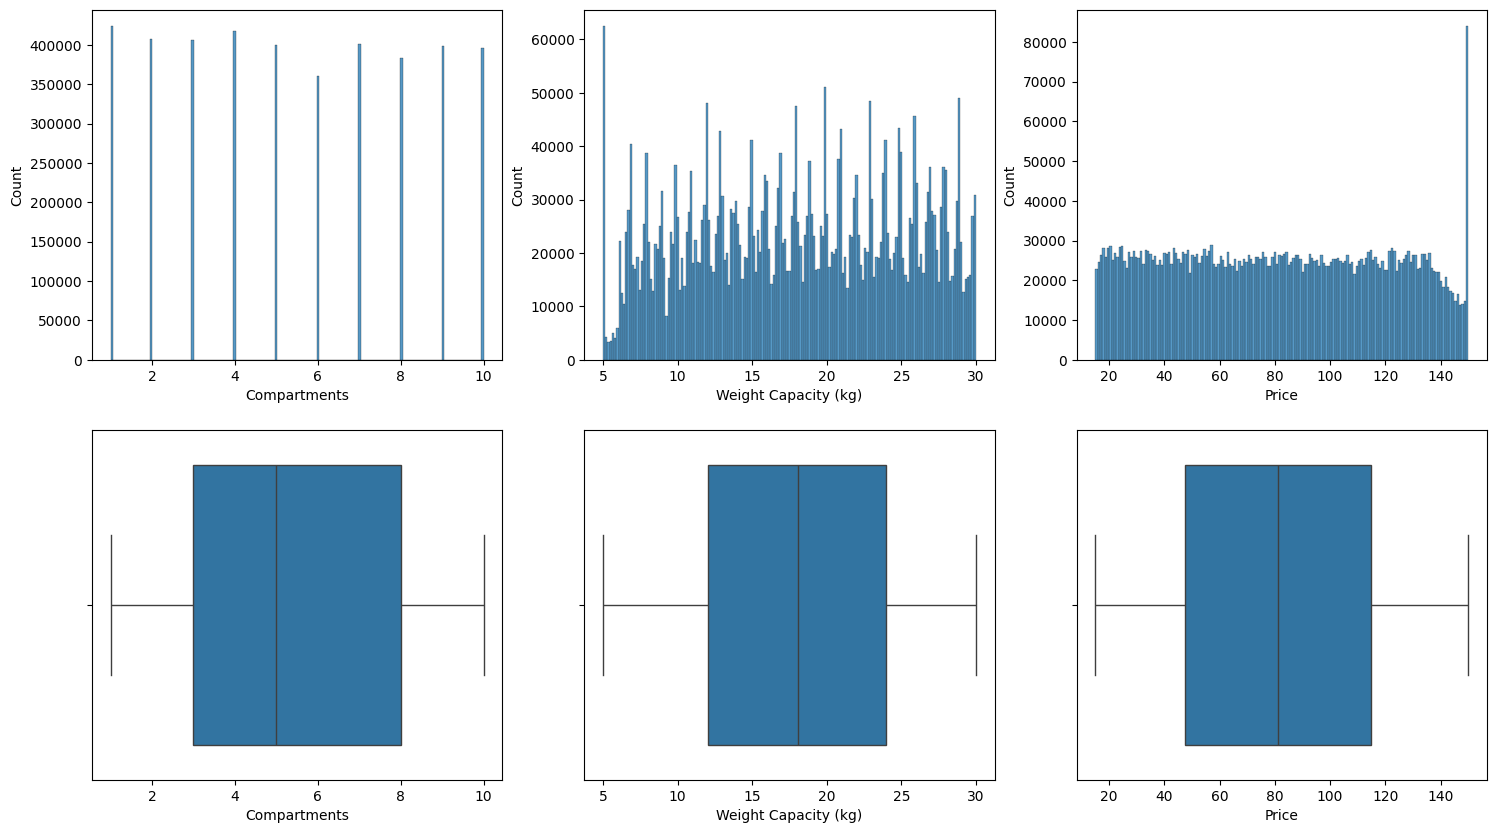

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,10))

sns.histplot(data=train_df, x='Compartments', ax=ax[0,0])
sns.histplot(data=train_df, x='Weight Capacity (kg)', ax=ax[0,1])
sns.histplot(data=train_df, x='Price', ax=ax[0,2])

sns.boxplot(data=train_df, x='Compartments', ax=ax[1,0])
sns.boxplot(data=train_df, x='Weight Capacity (kg)', ax=ax[1,1])
sns.boxplot(data=train_df, x='Price', ax=ax[1,2])

plt.show()

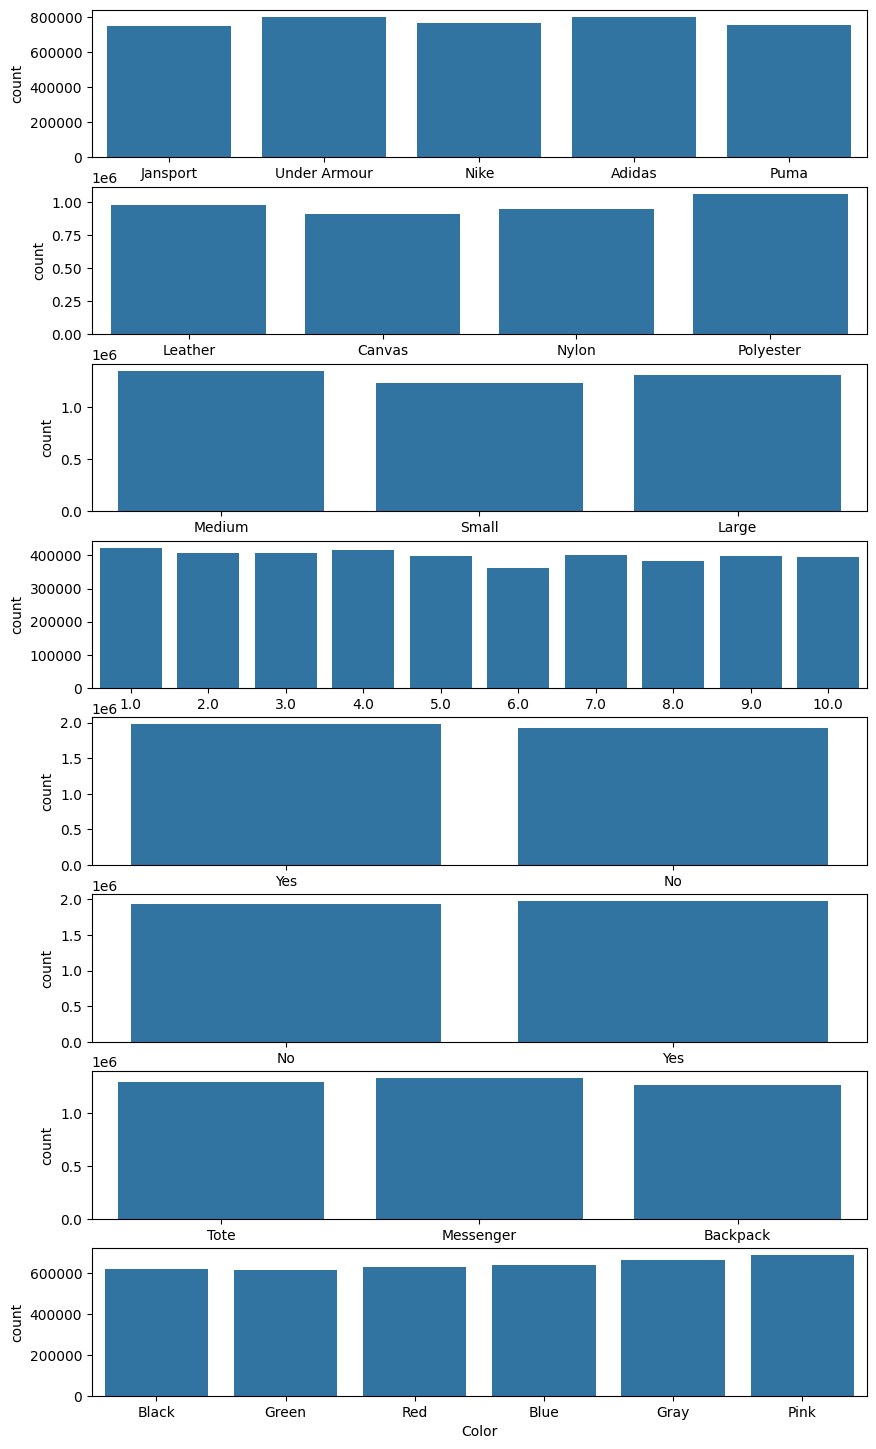

In [12]:
fig, ax = plt.subplots(nrows=len(CATEGORIC_COLUMNS), ncols=1, figsize=(10,18))


for i, category in enumerate(CATEGORIC_COLUMNS):
    sns.countplot(
        data=train_df[[category]],
        x=category,
        ax=ax[i]
    )

<Axes: >

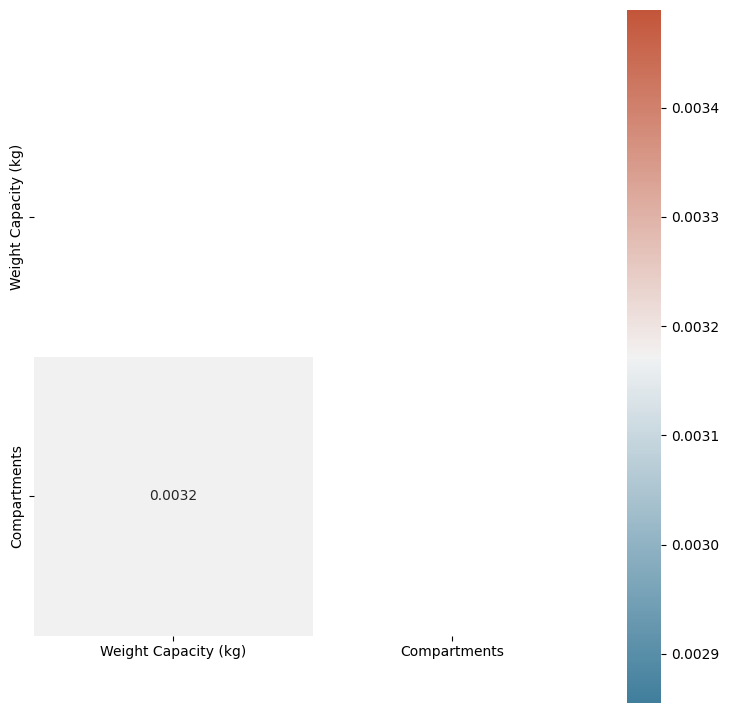

In [13]:
correlation = train_df[NUMERIC_COLUMNS+['Compartments']].corr()

mask = np.triu(np.ones_like(correlation, dtype=bool))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    correlation,
    mask=mask,
    cmap=cmap,
    annot=True,
    square=True, 
    ax=ax
)

In [ ]:
# Nan Handling
# for the time being, impute mode 0, reinvestigate others later, maybe use class like knn

print(train_df.isna().sum().values)

def imputations(df):
    # brand
    df['Brand'] = df['Brand'].fillna(df['Brand'].mode()[0])
    # material
    df['Material'] = df['Material'].fillna(df['Material'].mode()[0])
    # size
    df['Size'] = df['Size'].fillna(df['Size'].mode()[0])
    # compartments
    df['Compartments'] = df['Compartments'].fillna(df['Compartments'].mode()[0])
    # Laptop compaprtment
    df['Laptop Compartment'] = df['Laptop Compartment'].fillna(df['Laptop Compartment'].mode()[0])
    # Waterproof
    df['Waterproof'] = df['Waterproof'].fillna(df['Waterproof'].mode()[0])
    # Style
    df['Style'] = df['Style'].fillna(df['Style'].mode()[0])
    # Color
    df['Color'] = df['Color'].fillna(df['Color'].mode()[0])
    # Weight
    df['Weight Capacity (kg)'] = df['Weight Capacity (kg)'].fillna(df['Weight Capacity (kg)'].median())
    return df

# train_df = imputations(train_df)
# test_df = imputations(test_df)

print(train_df.isna().sum().values)

[126758 110962  87785      0  98533  94324 104180 133617   1808      0]
[0 0 0 0 0 0 0 0 0 0]


In [15]:
# feature engineering
# add combinations of categories
# or transform numerics in categories/bins

def add_features(df):

    df['Weight_bin'] = pd.cut(df['Weight Capacity (kg)'], bins=5, labels=['Low', 'Medium Low', 'Medium', 'Medium high', 'High'])
    return df

CATEGORIC_COLUMNS = CATEGORIC_COLUMNS + ['Weight_bin']

train_df = add_features(train_df)
test_df = add_features(test_df)

In [16]:

target = train_df[TARGET_COLUMN]
train = train_df.drop(columns=TARGET_COLUMN)
test = test_df

In [17]:
train

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Weight_bin
id,,,,,,,,,,
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,Medium Low
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,High
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,Medium
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,Medium Low
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,Medium
...,...,...,...,...,...,...,...,...,...,...
4194313,Nike,Canvas,Medium,3.0,Yes,Yes,Messenger,Blue,28.098120,High
4194314,Puma,Leather,Small,10.0,Yes,Yes,Tote,Blue,17.379531,Medium
4194315,Jansport,Canvas,Large,10.0,No,No,Backpack,Red,17.037708,Medium


In [ ]:
transformer = ColumnTransformer(
    transformers=[
        ('categories', OneHotEncoder(sparse_output=False), CATEGORIC_COLUMNS),
        ('weight', MinMaxScaler(), ['Weight Capacity (kg)']),
    ], remainder='passthrough'
)

pipe = Pipeline(
    steps=[
        ('transform_columns', transformer),
        ('targetencoder', TargetEncoder(
            target_type='continuous',
            random_state=42
        )),
        ('regression', LGBMRegressor())
        ]
        )


In [19]:
cv_results = cross_validate(
    pipe,
    train,
    target,
    cv=KFold(n_splits=10, shuffle=True, random_state=42),
    scoring="neg_root_mean_squared_error",
    n_jobs=3
)

errors = pd.Series(
    -cv_results["test_score"]
)
errors.describe()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 335
[LightGBM] [Info] Number of data points in the train set: 3594886, number of used features: 41
[LightGBM] [Info] Start training from score 81.355173
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.375868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 335
[LightGBM] [Info] Number of data points in the train set: 3594886, number of used features: 41
[LightGBM] [Info] Start training from score 81.368408
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGB

count    10.000000
mean     38.899042
std       0.041397
min      38.857167
25%      38.864757
50%      38.892108
75%      38.909235
max      38.979205
dtype: float64

In [20]:
from sklearn.model_selection import GridSearchCV

cv_search = GridSearchCV(
    estimator = pipe,
    param_grid={
        'regression__n_estimators':[100, 50, 10],
    },
    scoring="neg_root_mean_squared_error",
    cv=KFold(n_splits=10, shuffle=True, random_state=42),
    n_jobs=3,
)

search_results = cv_search.fit(
    train,
    target
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 335
[LightGBM] [Info] Number of data points in the train set: 3594886, number of used features: 41
[LightGBM] [Info] Start training from score 81.355173
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.455414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 335
[LightGBM] [Info] Number of data points in the train set: 3594886, number of used features: 41
[LightGBM] [Info] Start training from score 81.368408
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGB

In [21]:
pd.DataFrame(cv_search.cv_results_).T

,0,1,2
mean_fit_time,96.67212,52.68202,14.212366
std_fit_time,53.652929,38.657441,1.549165
mean_score_time,2.875934,1.915184,1.340211
std_score_time,0.524351,0.244346,0.253012
param_regression__n_estimators,100,50,10
params,{'regression__n_estimators': 100},{'regression__n_estimators': 50},{'regression__n_estimators': 10}
split0_test_score,-38.895541,-38.897032,-38.909986
split1_test_score,-38.857167,-38.85929,-38.872489
split2_test_score,-38.857281,-38.858642,-38.871066
split3_test_score,-38.880133,-38.881613,-38.894026


In [22]:
sub_df = pd.DataFrame(
    index=test.index,
    data={
        'num_sold':cv_search.predict(test)
    }
)
sub_df    

,num_sold
id,
300000,81.047293
300001,82.586092
300002,82.034167
300003,81.761091
300004,77.546983
...,...
499995,79.936539
499996,78.061342
499997,82.997834


In [23]:
if KAGGLE_RUN:
    sub_df.to_csv("/kaggle/working/submission.csv")
    !head /kaggle/working/submission.csv